In [9]:
from feature_extraction_pipeline.open_data_marine_weather.core import MarineWeatherExtractor
from feature_extraction_pipeline.open_data_raw_material_price.core import RawMaterialPriceExtractor
from feature_extraction_pipeline.open_data_terrestrial_weather.core import TerrestrialWeatherExtractor
import pandas as pd
import numpy as np



def load_data(date: str):
    price, p_key = RawMaterialPriceExtractor(date=date).process()
    t_weather, t_key = TerrestrialWeatherExtractor(date=date).process()
    m_weather, m_key = MarineWeatherExtractor(date=date).process()

    # combine data
    weather = pd.merge(
        t_weather.groupby(["일시"]).mean(),
        m_weather.groupby(["일시"]).mean(),
        how='inner', left_on=t_key, right_on=m_key
    ).reset_index()

    return pd.merge(
        price, weather, 
        how="left", left_on=p_key, right_on=t_key
    ).drop("일시", axis=1).astype(dtype={"조사일자": "datetime64"})

data201908 = load_data("201908")
data201907 = load_data("201907")

dataset = data201908.append(data201907).sort_values(by="조사일자", ascending=True)

# print(dataset)
# print(dataset.to_numpy())

# print(dataset["조사일자"].drop_duplicates().tolist())

2020-03-30 02:08:21:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 02:08:21:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 02:08:21:manager:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 02:08:30:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201907.csv in s3 'production-bobsim'
2020-03-30 02:08:31:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201907.csv in s3 'production-bobsim'
2020-03-30 02:08:31:manager:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201907.csv in s3 'production-bobsim'


            조사일자    당일조사가격  품목명_갈치류갈치은갈치냉동  품목명_갈치류갈치은갈치생선  품목명_감자감자수미수미  \
838   2019-07-01  6.320768               0               0             0   
402   2019-07-01  6.386879               0               0             0   
403   2019-07-01  5.298317               0               0             0   
404   2019-07-01  6.352629               0               0             0   
405   2019-07-01  7.668561               0               0             0   
...          ...       ...             ...             ...           ...   
39229 2019-08-30  4.110874               0               0             0   
39228 2019-08-30  5.648974               0               0             0   
39227 2019-08-30  5.852202               0               0             0   
39239 2019-08-30  6.261492               0               0             0   
40511 2019-08-30  7.609697               0               0             0   

       품목명_건가공(포)류건오징어오징어포일반  품목명_건가공(해조)류건미역자연미역일반  품목명_건제품건포도건포도(수입)수입  \
838        

In [22]:
filled = dataset.fillna(0)

In [207]:
time_series = filled["조사일자"].drop_duplicates()
reverse_series = time_series.sort_values(ascending=False)
reverse_series

39856   2019-08-30
37974   2019-08-29
36071   2019-08-28
34157   2019-08-27
32231   2019-08-26
30307   2019-08-23
28377   2019-08-22
26443   2019-08-21
24525   2019-08-20
22611   2019-08-19
19977   2019-08-16
18797   2019-08-14
16875   2019-08-13
14959   2019-08-12
13034   2019-08-09
11085   2019-08-08
9144    2019-08-07
7179    2019-08-06
5220    2019-08-05
3258    2019-08-02
1307    2019-08-01
41530   2019-07-31
39567   2019-07-30
37617   2019-07-29
35692   2019-07-26
33763   2019-07-25
31844   2019-07-24
29915   2019-07-23
28001   2019-07-22
26086   2019-07-19
24147   2019-07-18
21033   2019-07-17
20279   2019-07-16
18355   2019-07-15
16417   2019-07-12
14511   2019-07-11
12639   2019-07-10
10757   2019-07-09
8870    2019-07-05
6973    2019-07-04
5075    2019-07-03
3328    2019-07-02
838     2019-07-01
Name: 조사일자, dtype: datetime64[ns]

In [24]:
import collections

Dataset = collections.namedtuple("Dataset", ["train", "test"])

## adjust train volume fixing test last one day

In [150]:
from model.linear_regression import LinearRegressionModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import functools


reverse_list = reverse_series.tolist()

def plot(s: pd.Series):
    plt.hist(s, density=True)
    plt.show()

def split_xy(df: pd.DataFrame):
    # print(df.조사일자.drop_duplicates())
    return df.drop(columns=["당일조사가격", "조사일자"]), df["당일조사가격"]

def get_score(train, test):
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    regr = LinearRegressionModel(x_train, y_train)
    regr.fit()
    y_pred = regr.predict(x_test)
    # print(y_pred, y_test)
    
    # r_pred = np.expm1(y_pred)
    # r_test = np.expm1(y_test)
    
    # print(regr.score(), r2_score(y_test, y_pred))
    # print(r_pred, r_test)
    return mean_squared_error(y_test, y_pred, squared=True)

def adjust_train_volume(x, day, df: pd.DataFrame):
    train = df[(x <= df.조사일자.dt.date) & (df.조사일자.dt.date < day)]
    test = df[df.조사일자.dt.date >= day]
    return get_score(train, test)


[5.2833471726384795e+20, 1.6552433875618698e+21, 5.909139528531203e+18, 4.1995283219618e+18, 4.8954665390565006e+20, 6.13903135765386e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19, 3.3002833854692975e+19]


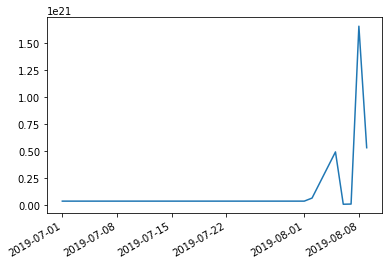

In [155]:
i = 7
standard_index = i
standard_day = reverse_list[i]
score_list = list(map(functools.partial(adjust_train_volume, day=standard_day, df=data201908), reverse_list[standard_index+i:]))
pd.Series(score_list, index=reverse_list[standard_index+i:]).plot()
print(score_list)

1
2
3
4


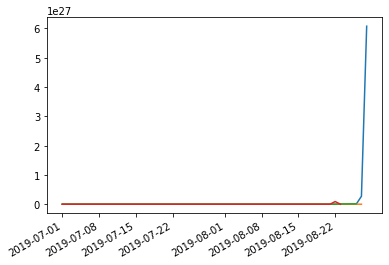

In [37]:
for i in range(1,5):
    print(i)
    standard_index = i
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(adjust_train_volume, day=standard_day, df=data201908), reverse_list[standard_index+1:]))
    pd.Series(score_list, index=reverse_list[standard_index+1:]).plot()


5
6
7
8
9


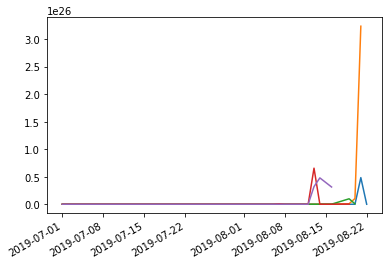

In [39]:
for i in range(5,10):
    print(i)
    standard_index = i
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(adjust_train_volume, day=standard_day, df=data201908), reverse_list[standard_index+1:]))
    pd.Series(score_list, index=reverse_list[standard_index+1:]).plot()


## Grid Search for ElasticNet

In [259]:
i = 0
standard_index = i
standard_day = reverse_list[i]
print(type(standard_day))

def train_test(df, day):
    return df[(reverse_list[i+2] < df.조사일자.dt.date) & (df.조사일자.dt.date < day)], df[df.조사일자.dt.date >= day]

train, test = train_test(filled, standard_day)
print(train, test)
X_train, Y_train = split_xy(train)
X_test, Y_test = split_xy(test)

print(mean_squared_error(Y_test, Y_train, squared=False))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
            조사일자  당일조사가격  품목명_갈치류갈치은갈치냉동  품목명_갈치류갈치은갈치생선  품목명_감자감자수미수미  \
37974 2019-08-29 6.55962               0               0             0   
37973 2019-08-29 5.31975               0               0             1   
37972 2019-08-29 8.08302               0               0             0   
37975 2019-08-29 7.21842               0               0             0   
37971 2019-08-29 7.54486               0               0             0   
...          ...     ...             ...             ...           ...   
37335 2019-08-29 7.41518               0               0             0   
37334 2019-08-29 6.28600               0               0             0   
37333 2019-08-29 4.62497               0               0             0   
37332 2019-08-29 7.68064               0               0             0   
37342 2019-08-29 5.78383               0               0             0   

       품목명_건가공(포)류건오징어오징어포일반  품목명_건가공(해조)류건미역자연미역일반  품목명_건제품

ValueError: Found input variables with inconsistent numbers of samples: [1915, 1887]

In [250]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA


In [251]:


# Use grid search to tune the parameters:
params = {
    "max_iter": [1, 5, 10],
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}

eNet = ElasticNet()
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(eNet, params, scoring='neg_root_mean_squared_error', cv=tscv.split(X_train))
grid.fit(X_train, Y_train)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.842187213193194, tolerance: 0.04860615180247702
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.570975757553256, tolerance: 0.09822193643037302
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.027131248767176, tolerance: 0.14745453878747752
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0741732659761523, tolerance: 0.04860615180247702
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1123209172275743, tolerance: 0.09822193643037302
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.338676477012605, tolerance: 0.14745453878747752
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mi

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.292081196702583, tolerance: 0.14745453878747752
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3860983432673666, tolerance: 0.04860615180247702
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5541813078676583, tolerance: 0.09822193643037302
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You m

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.808435885415605, tolerance: 0.09822193643037302
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.74214023944043, tolerance: 0.14745453878747752
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.543395197573464, tolerance: 0.04860615180247702
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You mig

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5629488976654073, tolerance: 0.04860615180247702
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0024615810986006, tolerance: 0.09822193643037302
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4342463329389545, tolerance: 0.14745453878747752
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You m

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.339892252163338, tolerance: 0.04860615180247702
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.963290156720745, tolerance: 0.09822193643037302
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.022134843963215, tolerance: 0.14745453878747752
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You m

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242.7231234614096, tolerance: 0.04860615180247702
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.5272732387652, tolerance: 0.09822193643037302
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 736.4134414809118, tolerance: 0.14745453878747752
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You migh

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000273D0ABC548>,
             error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [252]:
Y_pred = grid.predict(X_test)
mean_squared_error(Y_test, Y_pred, squared=True)

0.0327468839186593

In [253]:
r_pred = np.expm1(Y_pred)
r_test = np.expm1(Y_test)
print(r_pred, r_test)
print(mean_absolute_error(r_test, r_pred))
print(mean_squared_error(r_test, r_pred, squared=False))

y_sub = np.sort(np.absolute(np.subtract(r_pred, r_test)))
print(y_sub)

[2187.27881794 3918.31284001 4234.08360037 ...  299.21938155  516.86807278
 2057.04546623] 39856   2580.00000
39872   3990.00000
39873   4400.00000
39874   3480.00000
39879   1198.00000
           ...    
39229     60.00000
39228    283.00000
39227    347.00000
39239    523.00000
40511   2016.66667
Name: 당일조사가격, Length: 1915, dtype: float64
251.9929856626427
549.2182999040378
[2.70374747e-02 1.00655150e-01 1.35724629e-01 ... 5.20508114e+03
 6.14989853e+03 7.02516929e+03]


In [254]:
grid.get_params()

{'cv': <generator object TimeSeriesSplit.split at 0x00000273D0ABC548>,
 'error_score': nan,
 'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.5,
 'estimator__max_iter': 1000,
 'estimator__normalize': False,
 'estimator__positive': False,
 'estimator__precompute': False,
 'estimator__random_state': None,
 'estimator__selection': 'cyclic',
 'estimator__tol': 0.0001,
 'estimator__warm_start': False,
 'estimator': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'max_iter': [1, 5, 10],
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
  'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': '

In [255]:
elastic_net = grid.best_estimator_

elastic_net.fit(X_train, Y_train)
print(elastic_net.score(X_train, Y_train))
Y_pred = elastic_net.predict(X_test)
print(r2_score(Y_test,Y_pred))
r_pred = np.expm1(Y_pred)
r_test = np.expm1(Y_test)
print(r_pred, r_test)
print(mean_squared_error(r_test, r_pred, squared=False))

# Y_pred = elastic_net.predict(X_test)



0.9737069204298983
0.9681263050152779
[2187.27881794 3918.31284001 4234.08360037 ...  299.21938155  516.86807278
 2057.04546623] 39856   2580.00000
39872   3990.00000
39873   4400.00000
39874   3480.00000
39879   1198.00000
           ...    
39229     60.00000
39228    283.00000
39227    347.00000
39239    523.00000
40511   2016.66667
Name: 당일조사가격, Length: 1915, dtype: float64
549.2182999040378


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.099907356088522, tolerance: 0.1927870958947749
  positive)


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54053 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48521 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47788 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

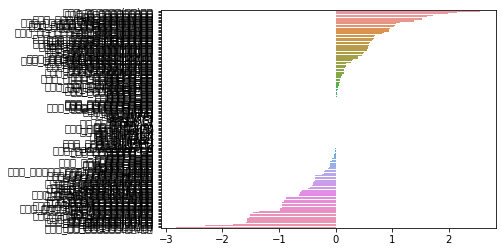

In [256]:
pd.options.display.float_format = '{:.5f}'.format

import seaborn as sns
def plot_coef(model):
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    return coef_sort
    
   
l_coef = plot_coef(elastic_net)

In [257]:
final = l_coef.reset_index().rename(columns={"index": "col"})
print(final)
m_list = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최대 풍속(m/s)', '평균 풍속(m/s)', '최소 상대습도(pct)', '평균 상대습도(pct)', '합계 일조시간(hr)', '강수 계속시간(hr)', '일강수량(mm)']

def func(x):
    print(final[final.col == x])
    return None

list(map(func , m_list))

                     col        0
0       품목명_수박수박수박(일반)일반  2.55618
1          품목명_한우쇠고기안심안심  2.14059
2        품목명_한우쇠고기등심한우등심  1.98793
3          품목명_메론멜론네트계일반  1.71417
4           품목명_포도포도거봉거봉  1.61538
..                   ...      ...
148     품목명_우유우유우유(일반)일반 -1.57293
149         품목명_벼쌀일반계일반계 -1.58411
150         품목명_감자감자수미수미 -1.81007
151     품목명_양파양파기타양파(일반) -2.30796
152  품목명_미나리미나리미나리(일반)일반 -2.82025

[153 rows x 2 columns]
         col       0
76  평균기온(°C) 0.00000
         col       0
77  최저기온(°C) 0.00000
         col        0
79  최고기온(°C) -0.00000
           col       0
83  최대 풍속(m/s) 0.00000
Empty DataFrame
Columns: [col, 0]
Index: []
             col       0
72  최소 상대습도(pct) 0.00000
Empty DataFrame
Columns: [col, 0]
Index: []
            col       0
86  합계 일조시간(hr) 0.00000
            col        0
89  강수 계속시간(hr) -0.00000
         col       0
91  일강수량(mm) 0.00000


[None, None, None, None, None, None, None, None, None, None]